# Exploration of the Ford GoBike System Data
## by (Dmitrij Burlak)



## Preliminary Wrangling
Is done in the notebook DownloadAndCleanData

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
%%time
rides_all = pd.read_csv('data/rides.csv', index_col=False);
rides = rides_all.copy()

Wall time: 14.7 s


### What is the structure of your dataset?
There are 1740396 rides in the dataset with 24 anonymized features 
- Trip Duration (seconds)
- Start Time and Date
- End Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude
- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)
- Member Year of Birth
- Member Gender

Dreived features 
- User Age
- Start Daytime	
- End Daytime	
- Start Weekday	
- End Weekday	
- Start Month
- Path

Most variables are nominal in nature, but the variables duration and age are numeric variables.
The ordinal variable user_type, start_month, start/end_weekday are ordered with the following levels:

User Type: Customer -> Subscriber
Start/End Daytime: 'morning' ->'afternoon' -> 'evening' -> 'night' -> 'dawn'
Start/End Weekday: 1 -> ... -> 7	
Start Month: 1 -> ... -> 12

### What is/are the main feature(s) of interest in your dataset?

In order to answer some question of interest like:

+ How long does the average trip take? Does this depend on if a user is a subscriber or customer or the location?
    - average trip (1d)
    - hist based on custumer type ( 2 hist in one only kde )
    - are there location specific differences? (3 * the above) 
    
+ What are the most used paths, meaning rides from one to another stations.
    - what are the 3 most frequent path in the dataset
    - what are the top 3 most frequent paths per locations
     

The following variable seem to be of interest:
Trip duration, User type Start time


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
Since time based analysis is important the derived features from start time will be the key to insights of this dataset.  

## Univariate Exploration

In this part we going to look into the distribution of duration, age, gender, type and if a bike was shared during the rides. 

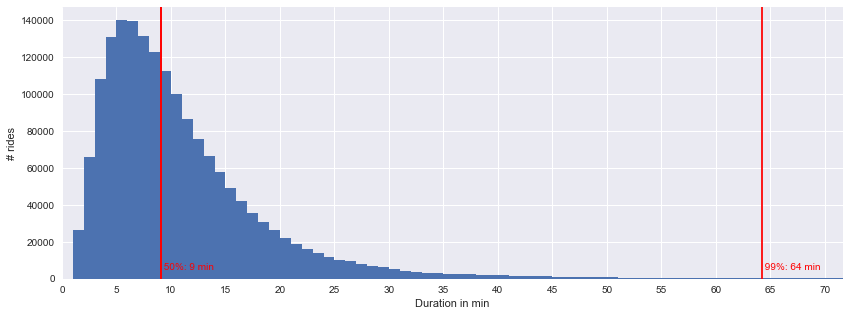

In [52]:
# How long does the average trip take/ start with a standard hist plot of ride duration
binsize = 60
bins = np.arange(0, rides['duration_sec'].max()+binsize, binsize)

plt.figure(figsize=[14, 5])
plt.hist(data = rides, x = 'duration_sec', bins = bins)
plt.xlabel('Duration in min')
xticks = np.arange(0,4000+300, 300)
xticksl= [int(x/60) for x in xticks]
plt.xticks(xticks,xticksl)
plt.xlim(0,4300)
plt.ylabel('# rides')
plt.axvline(rides.duration_sec.median(), color='r')


## The 99% line
uperPercentile = rides.duration_sec.quantile(0.99)
plt.axvline(uperPercentile, color='r')
plt.text(x=uperPercentile, y=5e3, s=' 99%: {} min'.format(int(uperPercentile/60)), color='r')

## The 50% line
median=rides.duration_sec.median()
plt.axvline(median, color='r')
plt.text(x=median, y=5e3, s=' 50%: {} min'.format(int(median/60)), color='r')
plt.show()

The series seems to be strongly right skewed so I'll check for a useful cutoff with percentils.

In [12]:
# duration is strongly right skewed
print(rides.duration_sec.quantile([.01,.25,.5,.99,.999]))

rides.duration_sec.describe()

0.010      106.00
0.250      344.00
0.500      543.00
0.990     3856.00
0.999    27873.42
Name: duration_sec, dtype: float64


count    1.740396e+06
mean     7.728238e+02
std      1.942687e+03
min      6.100000e+01
25%      3.440000e+02
50%      5.430000e+02
75%      8.390000e+02
max      8.628100e+04
Name: duration_sec, dtype: float64

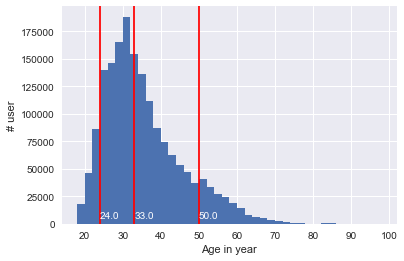

In [4]:
# another hist of age with 10% 50% and 75% quantiles 
bins = np.arange(18,100, 2)
plt.hist(data= rides, x='user_age', bins=bins);
plt.xlabel('Age in year')
plt.ylabel('# user');
quantiles = rides.user_age.quantile([0.1,0.5,0.9])
for q in quantiles.values:
    plt.axvline(q, color = 'r')
    plt.text(x=q, y = 5e3, s = q, color='w')

Around 50 year there seems to be another peek. In order to analyse this observation I'll look more in detail into a violinplot.

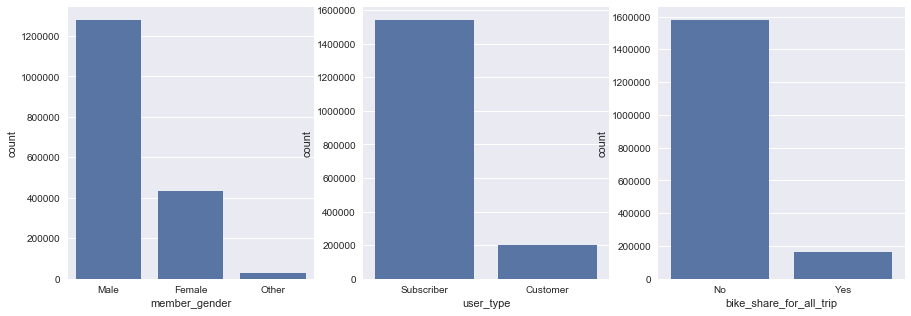

In [15]:
# Look into the categorical variables
plt.figure(figsize = [15,5])

plt.subplot(1, 3,1)
sns.countplot(data=rides, x = 'member_gender', color = sns.color_palette()[0]);

plt.subplot(1,3,2)
sns.countplot(data=rides, x = 'user_type', color = sns.color_palette()[0]);

plt.subplot(1,3,3)
sns.countplot(data=rides, x = 'bike_share_for_all_trip', color = sns.color_palette()[0]);


Most common user seems to be a male subscribtion without sharing the bike for all trip.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
We can see that the distribution for age and duration is strongly right skewed. The distribution of the categorical vars shows that the common user is a male subscriber without sharing the bike for all trip.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

As we could see in the distribution of duration of rides the most rides are taking less then 64 min. The extreme ride durations are though 86281. Because of this big range of values we will focus in further on the 99% of the data. Same for age distribution in further we assume that age over 100 is rather erroneously.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

+ Does the average trip length depends on customer type if a user is a subscriber or customer?


- What stations are full with bikes at the end of the day and which are empty?

- What are the most used paths, meaning rides from one to another stations! For further investigations age/ duration
- 2. find 5 stations with most incoming bikes
- 3. calculate in out ration of every station per day /month  
+ find top 5 most used path show by whom is it used (type user) 
+ duration vs age
+ separate cities vs duration

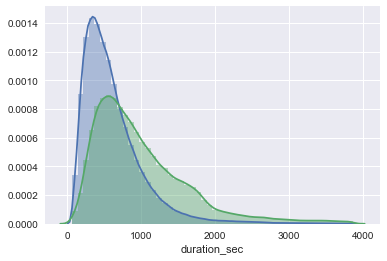

In [19]:
per_99=rides[rides.duration_sec < 3865]
sub=per_99[per_99.user_type == 'Subscriber']
cus=per_99[per_99.user_type == 'Customer']
sns.distplot( sub.duration_sec)
sns.distplot( cus.duration_sec)


Wall time: 3.76 s


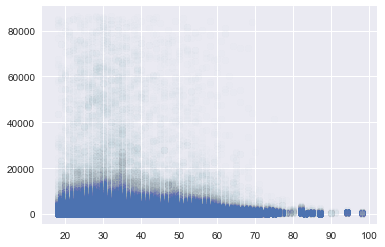

In [40]:
%%time
#duration vs. age
plt.scatter(data=rides, y='duration_sec', x = 'user_age', alpha=0.009);

As expected we observe a slight trend that shows with around 30 the ride duration is higher and decrease with growing age.  

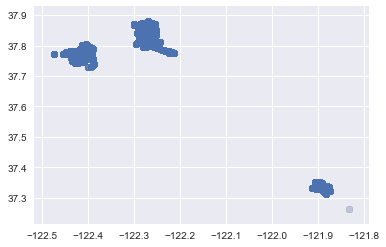

In [86]:
limit=rides[0:40]
plt.scatter(data =rides, y='start_station_latitude' , x='start_station_longitude', alpha=0.01);


Unexpected besides the three clusters for the major locations there is also a forth location next to SanJose. In further the identified point is treated as an outlier and will be removed from the data.    

In [252]:
unknownLocDf = rides[rides.start_station_longitude > -121.85]
rides = rides[rides.start_station_longitude < -121.85]

In [254]:

labels = ['SanFran', 'EastBay', 'SanJose']
bins = [-122.5,-122.35,-122.2,-121.85]

rides['location'] = pd.cut(rides.start_station_longitude, bins=bins, labels=labels, include_lowest= True)

Wall time: 6.25 s


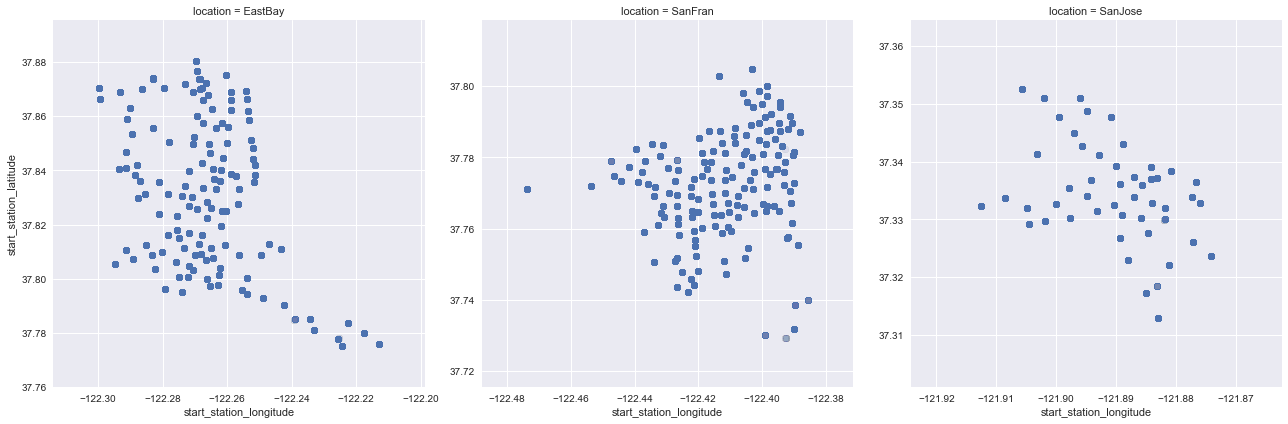

In [275]:
%%time
g = sns.FacetGrid(data=rides, col = 'location', size=6, sharey=False, sharex=False)
g.map(plt.scatter, 'start_station_longitude','start_station_latitude', alpha=0.01 );

Distribution of all stations in every officially supported location shows that the density of the stations is the highest in SanFran. Also we can see which areas are covered less.

In [255]:
# separate cities vs avg duration
rides.groupby('location').duration_sec.mean()

location
EastBay    719.439227
SanFran    794.831811
SanJose    681.910838
Name: duration_sec, dtype: float64

In [15]:
bestPaths = rides.groupby(['path']).path.count().sort_values(ascending=False)[0:5]
bestPaths

path
15-6       6057
6-16       4622
81-15      4292
196-182    3907
182-196    3727
Name: path, dtype: int64

In [16]:
#bestPaths.index.values
bestPathArr=['15-6', '6-16', '81-15', '196-182', '182-196']
bestPathDF = rides.query('path in {}'.format(bestPathArr))

path
15-6       875.718342
182-196    404.901261
196-182    404.862810
6-16       451.382302
81-15      704.866496
Name: duration_sec, dtype: float64

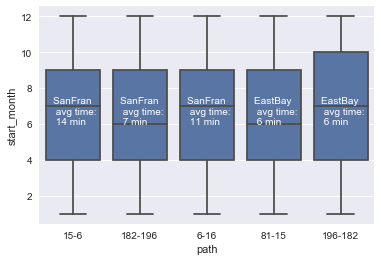

In [39]:
sns.boxplot(data=bestPathDF, x='path', y='start_month', color=sns.color_palette()[0]);
duration_avg = bestPathDF.groupby('path').duration_sec.mean()
for i in range(len(bestPathArr)):
    path = bestPathArr[i]
    loc = bestPathDF[bestPathDF.path==path].location.values[0]
    plt.text(x = i-0.3, y = 8 , s='{} \n avg time:\n {} min'.format(loc, int(duration_avg[path]/60)), color='w' )

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

- When are most trips started in terms of time of day, day of the week, or month of the year?

In [101]:
# neg values = more bikes out than in (meaning bikes need to be shiped in during night)
# pos values = more bikes in than out (meaning bikes need to be shiped out during night)
stationInOut = (rides.groupby('end_station_id').end_station_id.count() - rides.groupby('start_station_id').start_station_id.count()).sort_values()


stationInOut[0:5], stationInOut[-6:-1]

#station 374 has only one input and no output

(243   -8817.0
 52    -3661.0
 256   -3159.0
 253   -2905.0
 163   -2838.0
 dtype: float64, 245     3617.0
 21      3925.0
 15      5850.0
 30      7521.0
 67     11838.0
 dtype: float64)

In [133]:
rides.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_gender,bike_share_for_all_trip,user_age,start_daytime,end_daytime,start_weekday,end_weekday,start_month,path,location
0,75284,2018-01-31 22:52:35.239,2018-02-01 19:47:19.824,120,Mission Dolores Park,37.761420,-122.426435,285,Webster St at O'Farrell St,37.783521,...,Male,No,32,night,evening,2,3,1,120-285,SanFran
1,71576,2018-01-31 14:23:55.889,2018-02-01 10:16:52.116,304,Jackson St at 5th St,37.348759,-121.894798,296,5th St at Virginia St,37.325998,...,Male,No,22,afternoon,morning,2,3,1,304-296,SanJose
2,39966,2018-01-31 19:52:24.667,2018-02-01 06:58:31.053,74,Laguna St at Hayes St,37.776435,-122.426244,19,Post St at Kearny St,37.788975,...,Male,No,27,evening,morning,2,3,1,74-19,SanFran
3,453,2018-01-31 23:53:53.632,2018-02-01 00:01:26.805,110,17th & Folsom Street Park (17th St at Folsom St),37.763708,-122.415204,134,Valencia St at 24th St,37.752428,...,Male,No,30,night,dawn,2,3,1,110-134,SanFran
4,180,2018-01-31 23:52:09.903,2018-01-31 23:55:10.807,81,Berry St at 4th St,37.775880,-122.393170,93,4th St at Mission Bay Blvd S,37.770407,...,Male,No,38,night,night,2,2,1,81-93,SanFran


Wall time: 20.9 s


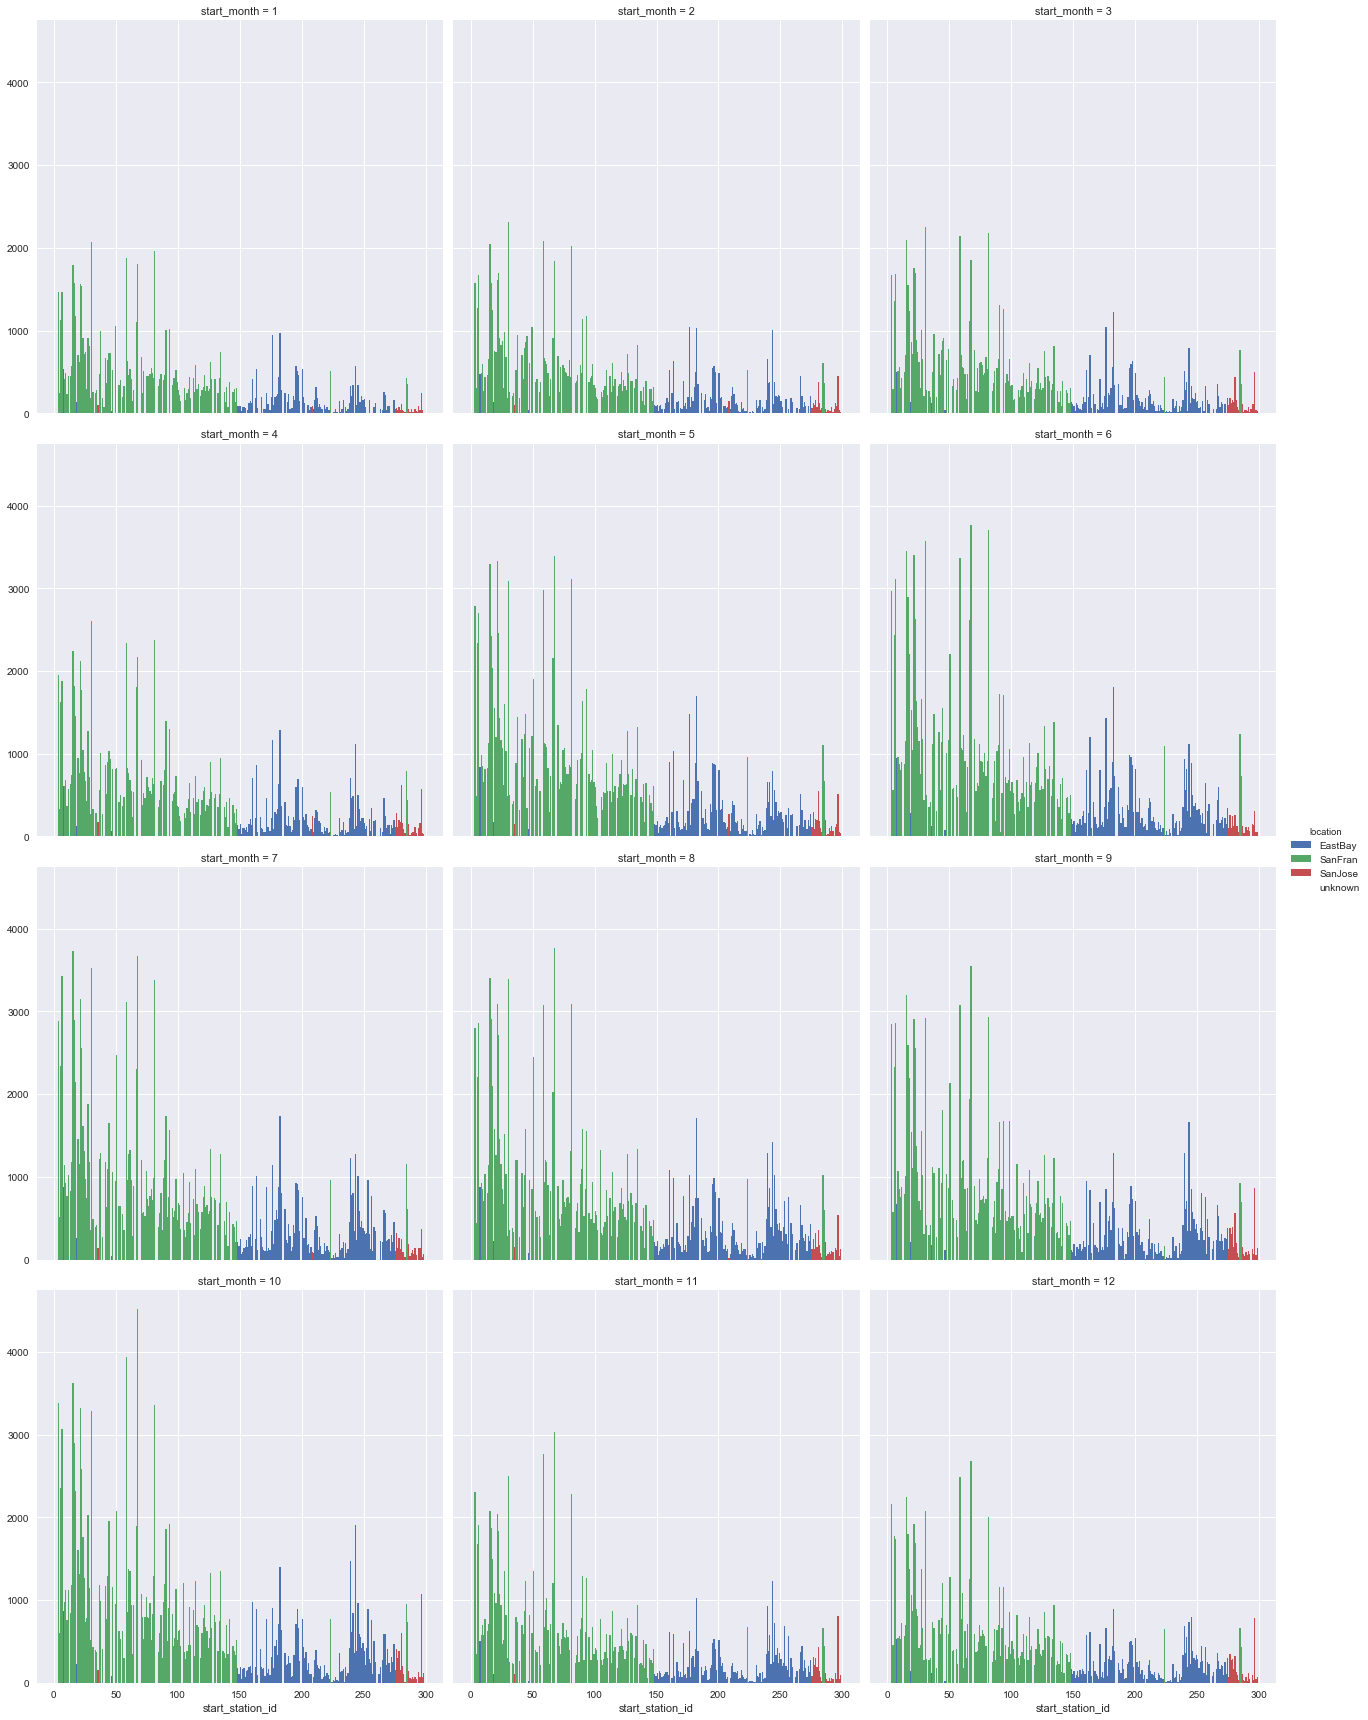

In [235]:
# month vs (start station id counts as hist), separated by location

g = sns.FacetGrid(data = rides, col = 'start_month', col_wrap=3, hue='location',size=6)
g.map(plt.hist, 'start_station_id', bins=np.arange(1,300,1))
g.add_legend()

As we can see the stationIds are mostly assigned linearly first 0 ~ 150 SanFran, 150 ~ 280 EastBay and 280 ~ 300 SanJose.
The amount of rides is growing, independent of location, towards October and is decreasing with the lowest amount of rides  towards January.

In [248]:
#order of locations based on location frequency
hueOrd=rides.location.value_counts().index.values

Wall time: 14 s


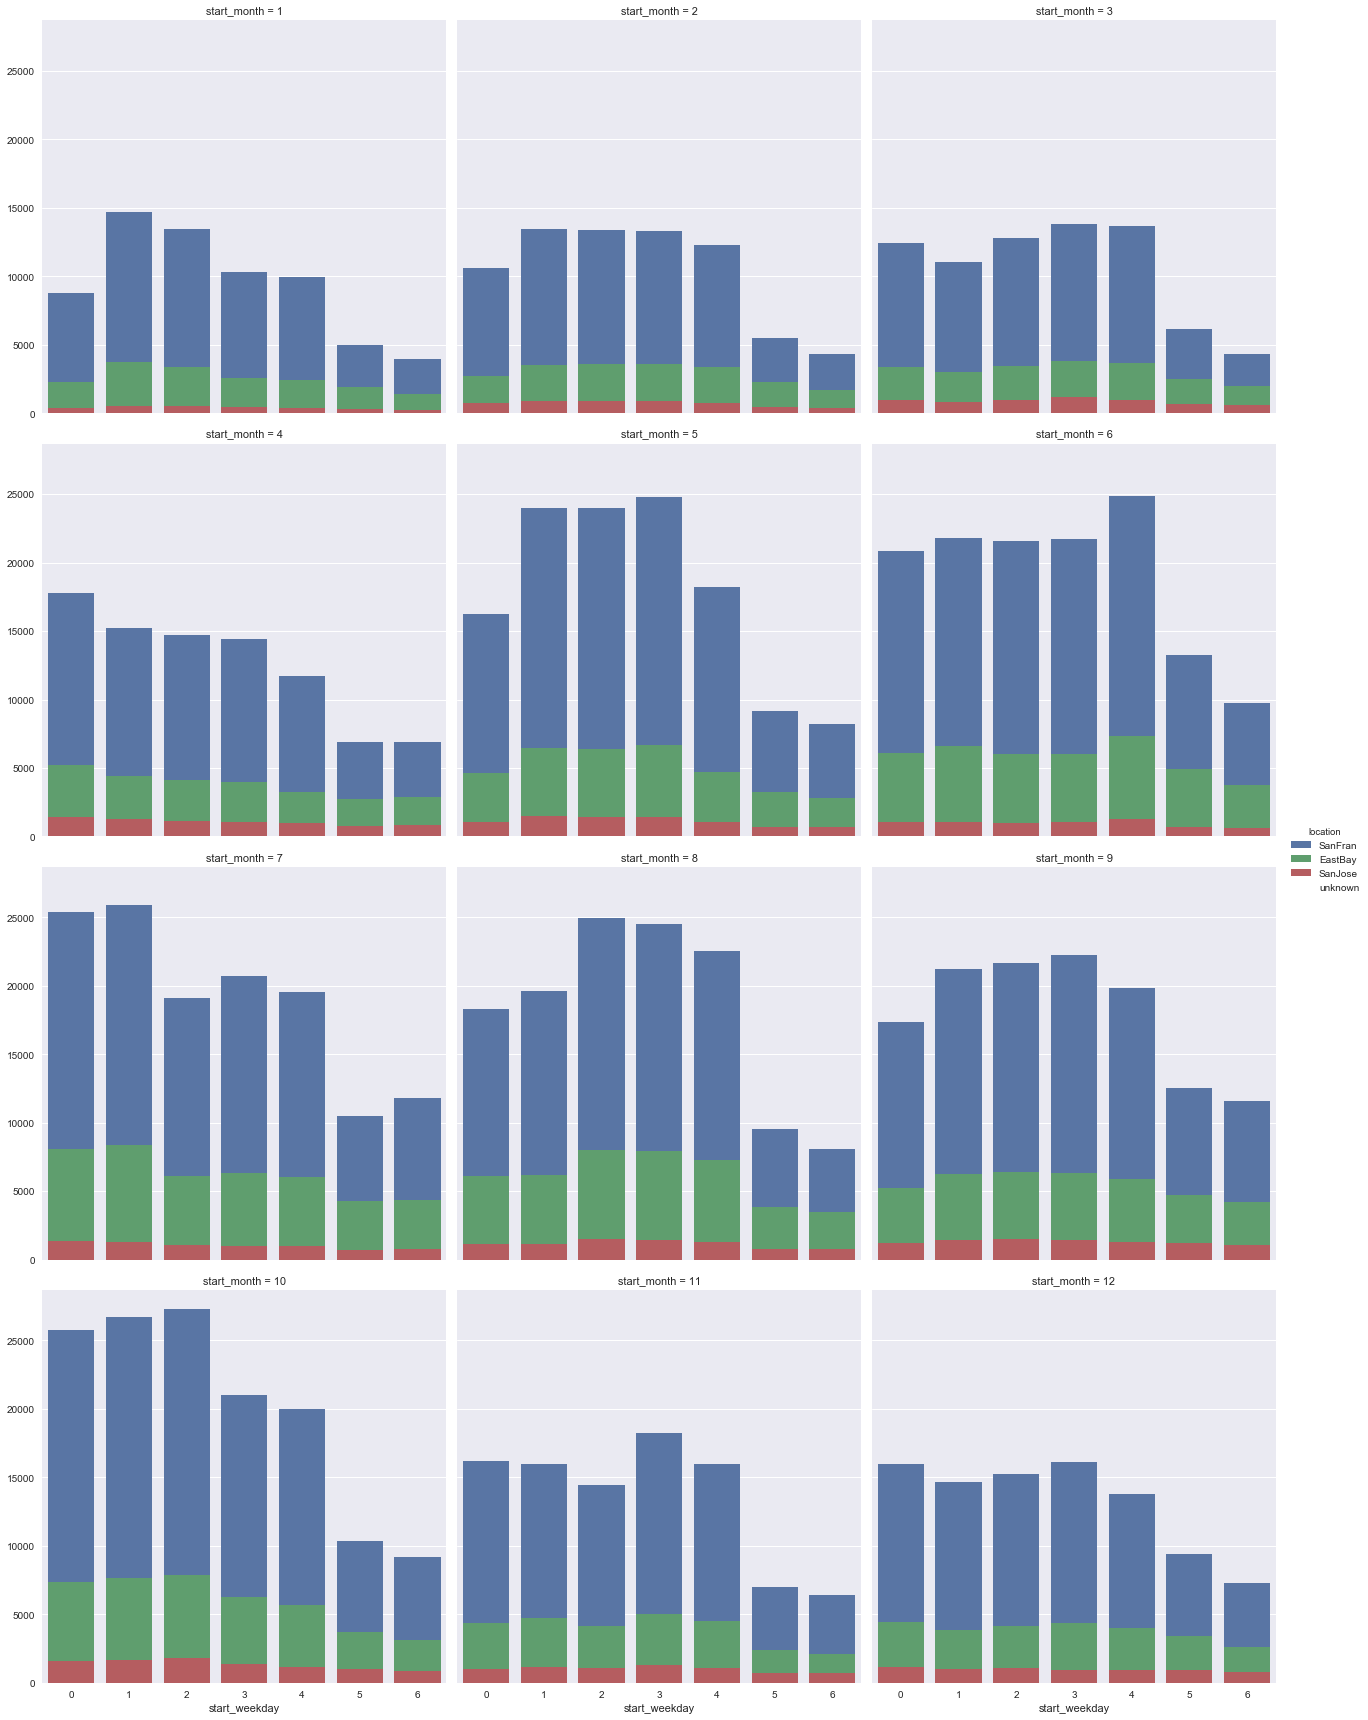

In [297]:
# month vs (start station id counts as hist), separated by location

g = sns.FacetGrid(data = rides, col = 'start_month', col_wrap=3, hue='location',size=6, hue_order=hueOrd)
g.map(sns.countplot, 'start_weekday')
g.add_legend()

Wall time: 42 s


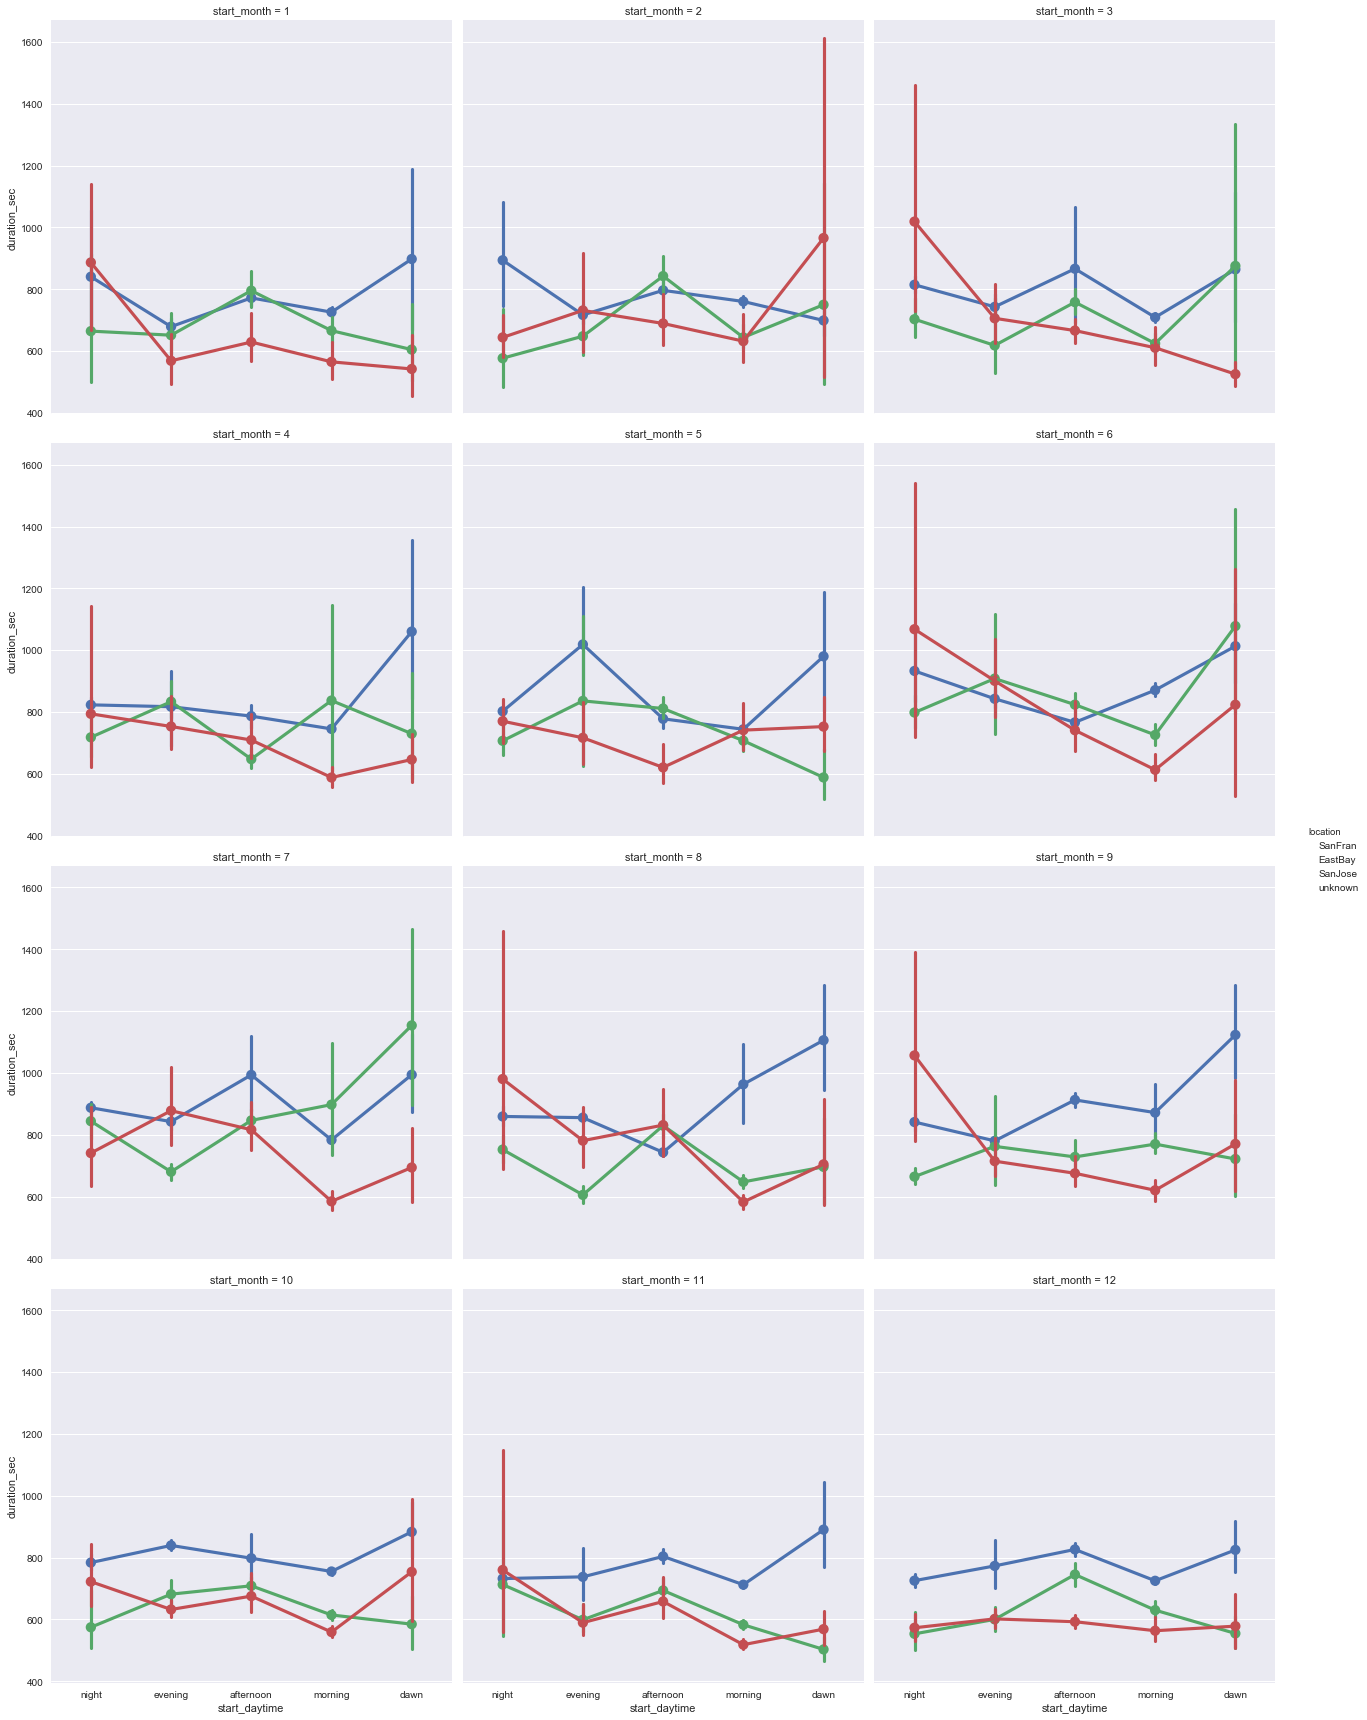

In [300]:
# month vs (start station id counts as hist), separated by location

g = sns.FacetGrid(data = rides, col = 'start_month', col_wrap=3, hue='location',size=6, hue_order=hueOrd)
g.map(sns.pointplot, 'start_daytime', 'duration_sec')
g.add_legend()

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

## Additional insights in to the extreme rides 0.001%

In [56]:
extreme_rides = rides[rides.duration_sec > 3856]

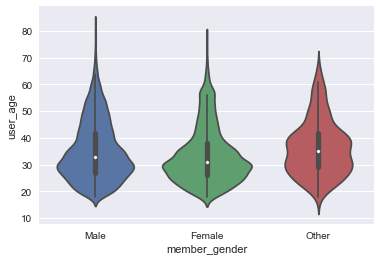

In [73]:
sns.violinplot(data=extreme_rides, y='user_age', x='member_gender');

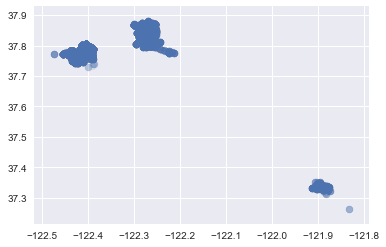

In [75]:
plt.scatter(data = extreme_rides, y='start_station_latitude' , x='start_station_longitude', alpha=0.1);

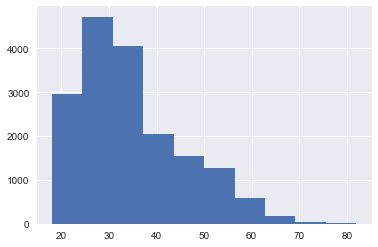

In [83]:
extreme_rides.user_age.hist();

In [304]:
rides.to_csv('data/rides_all_explored.csv', index=False);